In [1]:
from torch import utils, nn
from torchvision import datasets, transforms

In [2]:
# Load EMNIST Digits and Letters Datasets


train_digits_data = datasets.EMNIST(
    root="data", train=True, download=True, transform=transforms.ToTensor(), split="digits"
)
test_digits_data = datasets.EMNIST(
    root="data", train=False, download=True, transform=transforms.ToTensor(), split="digits"
)
train_letters_data = datasets.EMNIST(
    root="data", train=True, download=True, transform=transforms.ToTensor(), split="letters"
)
test_letters_data = datasets.EMNIST(
    root="data", train=False, download=True, transform=transforms.ToTensor(), split="letters"
)

100.0%


Extracting data\EMNIST\raw\gzip.zip to data\EMNIST\raw


In [3]:
# Combine Digits and Letters Datasets


train_digits_data.targets += 0; test_digits_data.targets += 0
train_letters_data.targets += 9; test_letters_data.targets += 9
train_data = utils.data.ConcatDataset([train_digits_data, train_letters_data])
test_data = utils.data.ConcatDataset([test_digits_data, test_letters_data])

In [4]:
# Create DataLoaders for Training and Testing


loaders = {
    "train": utils.data.DataLoader(
        train_data,
        batch_size=100,
        shuffle=True,
        num_workers=1,
    ),
    "test": utils.data.DataLoader(
        test_data,
        batch_size=100,
        shuffle=True,
        num_workers=1,
    ),
}

In [5]:
# Define Neural Network Model


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Define Convolution Layers
        self.convolutionlayer0 = nn.Conv2d(
            in_channels=1, out_channels=36, kernel_size=5
        )
        self.convolutionlayer1 = nn.Conv2d(
            in_channels=36, out_channels=72, kernel_size=5
        )
        # Define Dropout Layers
        self.dropoutlayer1 = nn.Dropout2d()
        # Define Fully Connected Layers
        self.fullyconnectedlayer0 = nn.Linear(in_features=1152, out_features=288)
        self.fullyconnectedlayer1 = nn.Linear(in_features=288, out_features=36)

    def forward(self, X):
        x = nn.functional.relu(nn.functional.max_pool2d(self.convolutionlayer0(X), 2))
        x = nn.functional.relu(
            nn.functional.max_pool2d(self.dropoutlayer1(self.convolutionlayer1(x)), 2)
        )
        x = x.view(-1, 1152)
        x = nn.functional.relu(self.fullyconnectedlayer0(x))
        x = nn.functional.dropout(x, training=self.training)
        x = self.fullyconnectedlayer1(x)

        return nn.functional.log_softmax(x, dim=1)

In [6]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
lossfn = nn.CrossEntropyLoss()


def train():
    model.train()
    for idx, (data, target) in enumerate(loaders["train"]):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = lossfn(output, target)
        loss.backward()
        optimizer.step()
        if idx % 100 == 0:
            print(
                "\n[{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    idx * len(data),
                    len(loaders["train"].dataset),
                    100.0 * idx / len(loaders["train"]),
                    loss.item(),
                )
            )


def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loaders["test"]:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += lossfn(output, target).item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(loaders["test"].dataset)
    print(
        "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)".format(
            test_loss,
            correct,
            len(loaders["test"].dataset),
            100.0 * correct / len(loaders["test"].dataset),
        )
    )

In [7]:
for epoch in range(1):
    train()
    test()


[0/364800 (0%)]	Loss: 3.592553

[10000/364800 (3%)]	Loss: 1.270215

[20000/364800 (5%)]	Loss: 0.735812

[30000/364800 (8%)]	Loss: 0.647381

[40000/364800 (11%)]	Loss: 0.590500

[50000/364800 (14%)]	Loss: 0.803185

[60000/364800 (16%)]	Loss: 0.793680

[70000/364800 (19%)]	Loss: 0.703719

[80000/364800 (22%)]	Loss: 0.567825

[90000/364800 (25%)]	Loss: 0.757775

[100000/364800 (27%)]	Loss: 0.563220

[110000/364800 (30%)]	Loss: 0.513632

[120000/364800 (33%)]	Loss: 0.432913

[130000/364800 (36%)]	Loss: 0.520607

[140000/364800 (38%)]	Loss: 0.627804

[150000/364800 (41%)]	Loss: 0.411762

[160000/364800 (44%)]	Loss: 0.524102

[170000/364800 (47%)]	Loss: 0.474515

[180000/364800 (49%)]	Loss: 0.651606

[190000/364800 (52%)]	Loss: 0.586742

[200000/364800 (55%)]	Loss: 0.338909

[210000/364800 (58%)]	Loss: 0.539549

[220000/364800 (60%)]	Loss: 0.295926

[230000/364800 (63%)]	Loss: 0.303354

[240000/364800 (66%)]	Loss: 0.353285

[250000/364800 (69%)]	Loss: 0.349511

[260000/364800 (71%)]	Loss: 0

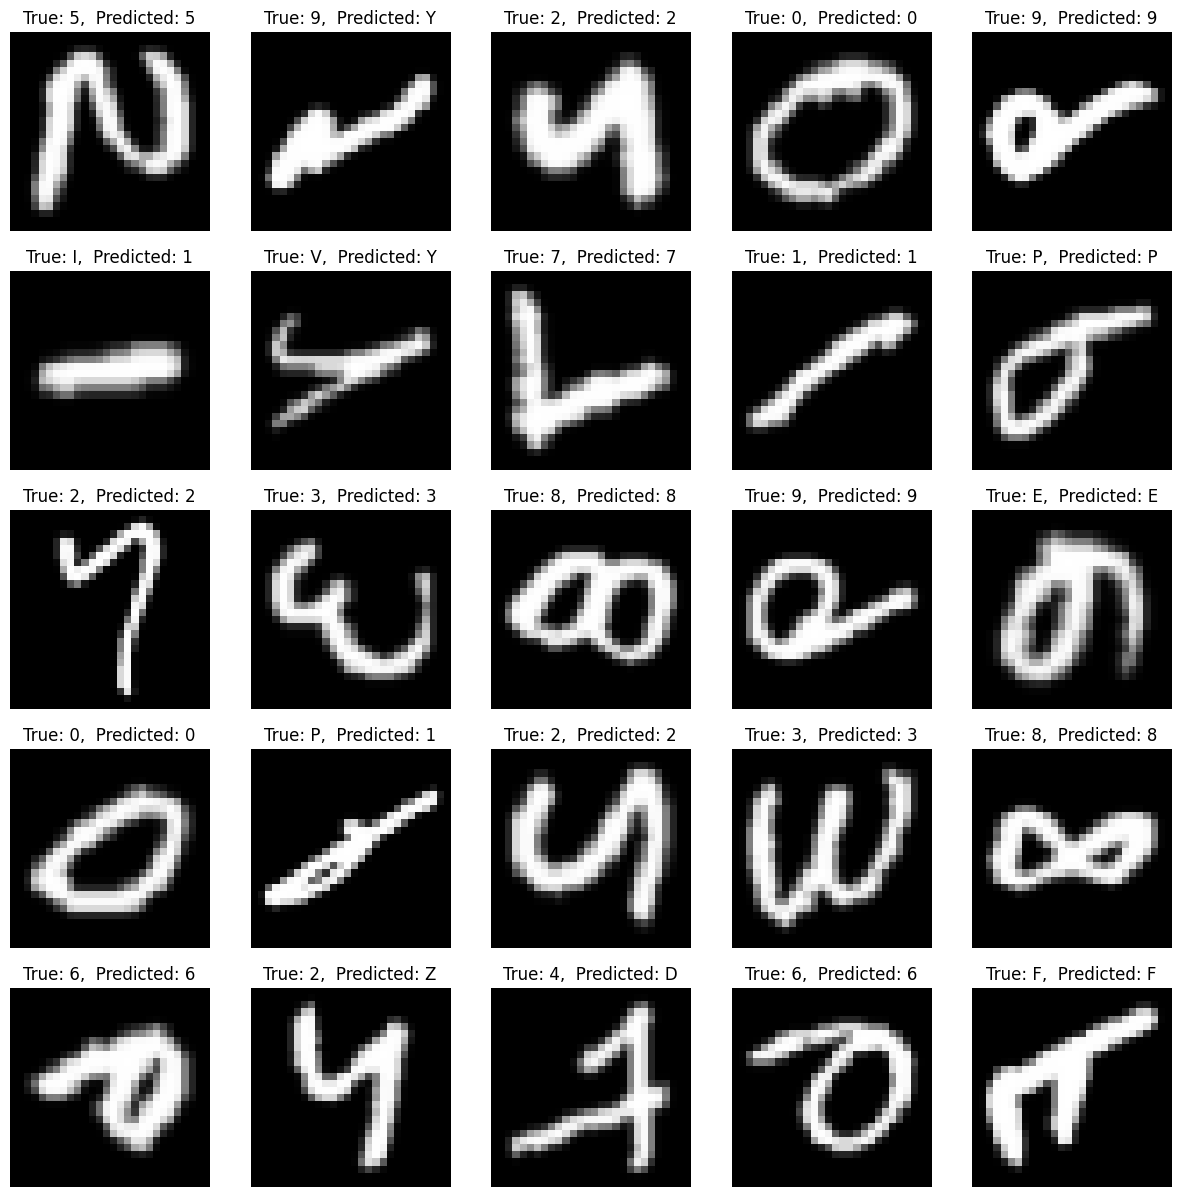

In [8]:
import numpy as np
import matplotlib.pyplot as plt

translations = {i: chr(48 + i) if i < 10 else chr(55 + i) for i in range(36)}


figure = plt.figure(figsize=(15, 15))
for p in range(25):
    idx = np.random.randint(0, len(test_data))
    data, target = test_data[idx]
    data = data.unsqueeze(0).to(device)
    output = model(data)
    pred = output.max(1, keepdim=True)[1]
    plt.subplot(5, 5, p + 1)
    plt.axis("off")
    plt.imshow(data[0][0].cpu(), cmap="gray")
    plt.title(
        "True: {},  Predicted: {}".format(
            translations[target], translations[pred.item()]
        )
    )
plt.show()